In [3]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
print(os.environ.get('IEX_SANDBOX_TOKEN'))
print(os.environ.get('IEX_TOKEN'))

Tsk_2f36139a7da4433bbc4882148386ff32
sk_adc1a33884d64226b0ad7b2e4a5f213e


In [2]:
base_url = 'https://cloud.iexapis.com/v1'
sandbox_url = 'https://sandbox.iexapis.com/stable'

token = os.environ.get('IEX_TOKEN')
sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
params = {'token': token}
sandbox_params = {'token': sandbox_token}


In [52]:
endpoint = '/stock/aapl/chart/3m'
# endpoint = '/stock/aapl/balance-sheet'
# endpoint = '/stock/aapl/financials'
# endpoint = '/time-series/reported_financials/AAPL/10-Q?last=2'
# endpoint = '/time-series'
# endpoint = '/stock/aapl/financials?period=quarter'

# endpoint = '/stock/aapl/price'
# endpoint = '/stock/aapl/income/10-Q?last=2'
# resp = requests.get(base_url+endpoint, params = params)
resp = requests.get(sandbox_url+endpoint, params = sandbox_params)
resp.raise_for_status()
resp = resp.json()

In [58]:
# resp

In [16]:
# If you plan to use this same endpoint a few times, it makes sense to create a function to avoid repeating code. Here is an example:

## Method 1: Corporate Profitability -- DuPont Analysis

In [8]:
def profitability(_symbol, _url='sandbox', _last=12):
    # Here we will calculate two indicators
    # 1. ROE = net income / (asset - liability) = Net Income (from income statement) /Stockholders' Equity (from balance sheet)
    # 2. gross profit
#     Driver 1: Net profit margin
#     Driver 2: Asset turnover ratio
#     Driver 3: Financial leverage
    
    # define parameters
    base_url    = 'https://cloud.iexapis.com/v1'
    sandbox_url = 'https://sandbox.iexapis.com/stable'

    base_token     = os.environ.get('IEX_TOKEN')
    sandbox_token  = os.environ.get('IEX_SANDBOX_TOKEN')
    base_params    = {'token': base_token}
    sandbox_params = {'token': sandbox_token}
    
    ticker_lower = f'{_symbol}'.lower() #IEX only accepts lower case ticker
    ticker_upper = f'{_symbol}'.upper() #Use upper case ticker for plotting
    
    incomeStat_url  = f'stock/{_symbol}/income'
    balanceStat_url = f'/stock/{_symbol}/balance-sheet'
    
    
    # _last defaul is 12; min is 1 (quarters)
    if _url == 'sandbox':
        incomeStat_endpoint = f'{sandbox_url}/{incomeStat_url}/?last={_last}'
        incomeStat_resp = requests.get(incomeStat_endpoint, params=sandbox_params)
        incomeStat_resp.raise_for_status()
        incomeStat_resp = incomeStat_resp.json()
        # Halt operation & return a statement in insufficient financial data scenario 
        if _last == 12 and len(incomeStat_resp['income']) < 12:
            print(f'Hey! {ticker_upper} is a relatively new IPO.\nThe company has published less than 3 years worth of financial data for us to perform a meaningful analysis.')
            return None
        
        balanceStat_endpoint = f'{sandbox_url}/{balanceStat_url}/?last={_last}'
        balanceStat_resp = requests.get(balanceStat_endpoint, params=sandbox_params)
        balanceStat_resp.raise_for_status()
        balanceStat_resp = balanceStat_resp.json()
        
    else: # need IEX subscription in order to support this url
        incomeStat_endpoint = f'{base_url}/{incomeStat_url}/?last={_last}'
        incomeStat_resp = requests.get(incomeStat_endpoint, params=base_params)
        incomeStat_resp.raise_for_status()
        incomeStat_resp = incomeStat_resp.json()
        
        balanceStat_endpoint = f'{base_url}/{balanceStat_url}/?last={_last}'
        balanceStat_resp = requests.get(balanceStat_endpoint, params=base_params)
        balanceStat_resp.raise_for_status()
        balanceStat_resp = balanceStat_resp.json()
        
    
    
    # extract fiscalDate / fiscalQuarter / netIncome / grossProfit frome income statement
    inc = []
    inc_qrt = {}
    for num in range(0,len(incomeStat_resp['income'])):
        for key in ('fiscalDate', 'fiscalQuarter', 'netIncome', 'grossProfit', 'totalRevenue'):
            inc_qrt[key] = incomeStat_resp['income'][num].setdefault(key)
        inc.append(inc_qrt)
        inc_qrt = {}
        
    # extract fiscalDate / fiscalQuarter / netIncome from balance sheet
    bs = []
    bs_qrt = {}
    for num in range(0,len(balanceStat_resp['balancesheet'])):
        for key in ('fiscalDate', 'fiscalQuarter', 'totalAssets', 'shareholderEquity'):
            bs_qrt[key] = balanceStat_resp['balancesheet'][num].setdefault(key)
        bs.append(bs_qrt)
        bs_qrt = {}
    
    
    # convert both data to df and merge
    inc_df = pd.DataFrame(inc)
    bs_df = pd.DataFrame(bs)
    df = pd.merge(inc_df, bs_df, on=['fiscalDate','fiscalQuarter'], how='left')
    
#     df['ROE (%)'] = df['netIncome'] / (df['totalAssets'] - df['totalLiabilities']) * 100
#     df['ROE (%)'] = round(df['ROE (%)'], 1)
    
    # Net profit margin (NPM)
    df['NPM'] = df['netIncome'] / df['totalRevenue']
    
    # Asset turnover (AT)
    df['AT'] = df['totalRevenue'] / df['totalAssets']
    
    # Equity Multiplier (EM)
    df['EM'] = df['totalAssets'] / df['shareholderEquity']
    
    # ROE = NPM x AT x EM
    df['roe(%)'] = round(df['NPM']*df['AT']*df['EM']*100,1)
    
    # use datetime format and sort df by date
    df['fiscalDate'] = pd.to_datetime(df['fiscalDate'], format='%Y/%m/%d')
    df = df.sort_values('fiscalDate')
    # transform date to year-month format
    df["date_yrmo"] = df['fiscalDate'].dt.strftime('%Y-%m')
    
    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Plotting
    fig = plt.figure(figsize=(16,9), dpi=100)
    ax = fig.add_subplot(111)

    ln1 = ax.plot(df.date_yrmo, df.AT, '-', label = 'Asset Turnover', color='tab:blue', linewidth=3)
    ln2 = ax.plot(df.date_yrmo, df.EM, '-', label = 'Equity Multiplier', color='tab:green', linewidth=3)
    ax2 = ax.twinx()
    ln3 = ax2.plot(df.date_yrmo, df.NPM, 'r', label = 'Net Profit Margin', color='tab:pink', linewidth=3)
    ln4 = ax2.plot(df.date_yrmo, df['roe(%)'], 'r', label = 'ROE', color='tab:red', linewidth=3)

    # combine three lines
    ln = ln1+ln2+ln3+ln4
    labs = [l.get_label() for l in ln]

    ax.legend(ln, labs, loc='upper right')#, ncol=3, mode = "expand")
    ax.set_title(f'{ticker_upper}: ROE and ROE Components', fontsize=16)
    ax.grid(alpha=.2)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_ylabel('Asset Turnover, Equity Multiplier', fontsize=16)
    ax2.set_ylabel('Net Profit Margin, ROE (%)', fontsize=16)
    fig.tight_layout()
    plt.show()
    #----------------------------------------------------------------------------------------------------------------------------------------------
   
    # return simple revenue history
    df = pd.DataFrame(df)
    df = df.sort_values('fiscalDate')
    
    
    return df
    

In [9]:
df = profitability('aapl', 'sandbox', 12)

In [7]:
type(df)

pandas.core.frame.DataFrame

In [6]:
 # save df
with open('df.pkl', 'wb') as f:
    pickle.dump(df, f)



In [ ]:
# read df
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)

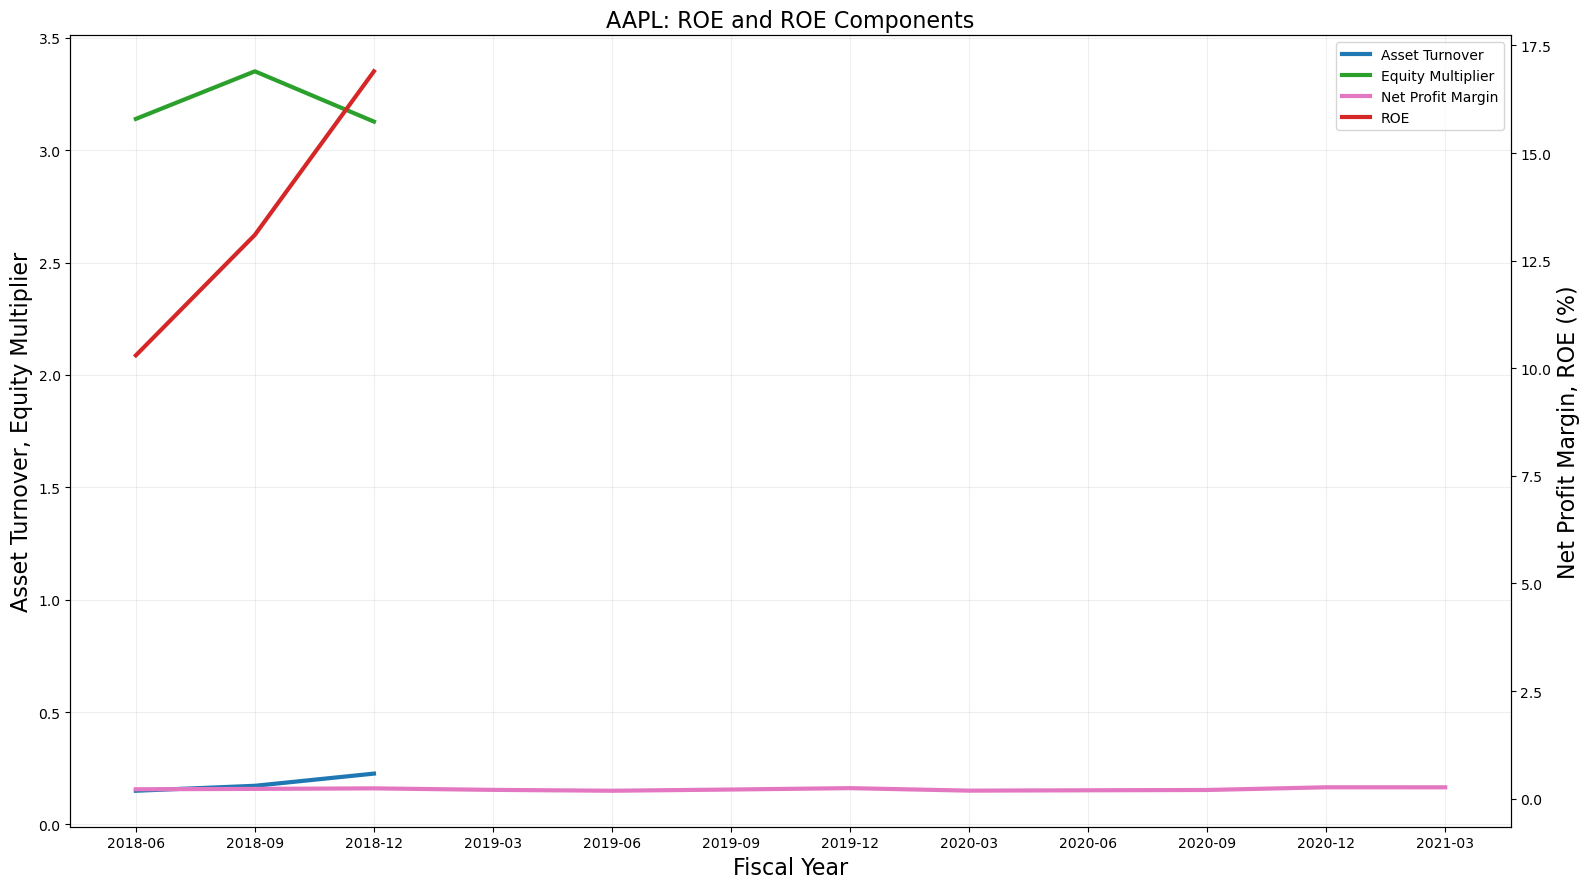

,fiscalDate,fiscalQuarter,netIncome,grossProfit,totalRevenue,totalAssets,shareholderEquity,NPM,AT,EM,roe(%),date_yrmo
11,2018-06-28,3,11879451727,20638855192,54472640859,3.633176e+11,1.157381e+11,0.218081,0.149931,3.139136,10.3,2018-06
10,2018-09-19,4,14470583797,24925867827,63751887627,3.706630e+11,1.106202e+11,0.226983,0.171994,3.350773,13.1,2018-09
9,2018-12-21,1,20784409308,32292149722,86905075949,3.841930e+11,1.228639e+11,0.239162,0.226202,3.126981,16.9,2018-12
8,2019-03-23,2,11965279827,22797238382,58589392656,NaN,NaN,0.204223,NaN,NaN,NaN,2019-03
7,2019-06-20,3,10117774244,20583074731,55050045986,NaN,NaN,0.183792,NaN,NaN,NaN,2019-06
6,2019-09-25,4,14171076899,24580646865,66747666771,NaN,NaN,0.212308,NaN,NaN,NaN,2019-09
5,2019-12-15,1,23232528959,35811272977,95110087032,NaN,NaN,0.244270,NaN,NaN,NaN,2019-12
4,2020-03-22,2,11296049162,22389916838,60648823804,NaN,NaN,0.186253,NaN,NaN,NaN,2020-03
3,2020-06-19,3,11705855867,22918419864,60162997363,NaN,NaN,0.194569,NaN,NaN,NaN,2020-06
2,2020-09-25,4,13258860714,25409161345,65729932282,NaN,NaN,0.201717,NaN,NaN,NaN,2020-09


In [3]:
profitability('aapl', 'sandbox', 12) # random output due to sandbox

In [ ]:
# _last defaul is 12; min is 1 (quarters)
endpoint = f'{sandbox_url}/{incomeStat_endpoint}'
resp = requests.get(endpoint, params=sandbox_params)
resp = requests.get(endpoint, params=base_params) # need IEX subscription in order to support this url
resp.raise_for_status()
resp = resp.json()

## Method 4: Corporate Growth -- Revenue Analysis

In [35]:
def growth(_symbol, _url='sandbox', _last=12):
    
    # define parameters
    base_url = 'https://cloud.iexapis.com/v1'
    sandbox_url = 'https://sandbox.iexapis.com/stable'

    base_token = os.environ.get('IEX_TOKEN')
    sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
    base_params = {'token': base_token}
    sandbox_params = {'token': sandbox_token}
    
    ticker_lower = f'{_symbol}'.lower() #IEX only accepts lower case ticker
    ticker_upper = f'{_symbol}'.upper() #Use upper case ticker for plotting
    
    # _last defaul is 12; min is 1 (quarters)
    if _url == 'sandbox':
        endpoint = f'{sandbox_url}/stock/{ticker_lower}/income/10-Q/?last={_last}'
        resp = requests.get(endpoint, params=sandbox_params)
    else:
        endpoint = f'{base_url}/stock/{ticker_lower}/income/10-Q/?last={_last}'
        resp = requests.get(endpoint, params=base_params) # need IEX subscription in order to support this url
    resp.raise_for_status()
    resp = resp.json()
    
    # Halt operation & return a statement in insufficient financial data scenario 
    if _last == 12 and len(resp['income']) < 12:
        print(f'Hey! {ticker_upper} is a relatively new IPO.\nThe company has published less than 3 years worth of financial data for us to perform a meaningful analysis.')
        return None
        
    rev = []
    rev_qrt = {}
    
    # extract date / quarter_number / quarterly_revenue
    for num in range(0,len(resp['income'])):
        for key in ('fiscalDate','fiscalQuarter','totalRevenue'):
            rev_qrt[key] = resp['income'][num].setdefault(key)
        rev.append(rev_qrt)
        rev_qrt = {}
    
    # add TTM_Revenue
    # the last 3 TTM Revenue would not be available
    for i in range(0,len(rev)):
        if (i+3) < len(rev):
            rev[i]['TTM_Revenue'] = rev[i]['totalRevenue'] + rev[i+1]['totalRevenue'] + rev[i+2]['totalRevenue'] + rev[i+3]['totalRevenue']
   
    # Calculate YoY quarterly & yearly revenue growth rate
    q=0
    y=0
    while q < 8: # YOY quarterly growth is calculated every 4 quarters, so 12 quarters of data can only derive 8 data points
        rev[q]['Quarterly_Revenue_Growth'] = round((rev[q]['totalRevenue']/rev[q+4]['totalRevenue']-1)*100,2)
        q += 1
    while y < 5: # YOY same period growth is calculated every 4 data points, so 12 quarters of data can only derive 5 data points   
        rev[y]['TTM_Revenue_Growth'] = round((rev[y]['TTM_Revenue']/rev[y+4]['TTM_Revenue']-1)*100,2)
        y += 1
    
    # Convert to pandas DF
    rev_df = pd.DataFrame(rev)  
    # rename totalRevenue to Quarterly_Revenue
    rev_df = rev_df.rename(columns={'totalRevenue': 'Quarterly_Revenue'})
    
    # remove df rows where quarterly_revenue_growth is NaN
    rev_df = rev_df.loc[0:7]
    # use datetime format and sort df by date
    rev_df['fiscalDate'] = pd.to_datetime(rev_df['fiscalDate'], format='%Y/%m/%d')
    rev_df = rev_df.sort_values('fiscalDate')
    # transform date to year-month format
    rev_df["date_yrmo"] = rev_df['fiscalDate'].dt.strftime('%Y-%m')
    
    # calculate monthly average stock price 
    if _url == 'sandbox':
        endpoint = f'{sandbox_url}/stock/{ticker_lower}/chart/39m'
        resp = requests.get(endpoint, params=sandbox_params)
    else:
        endpoint = f'{base_url}/stock/{ticker_lower}/chart/39m'
        resp = requests.get(endpoint, params=base_params) # need IEX subscription in order to support this url
    
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    df = df[["symbol","date","fClose","fVolume"]]
    # transform date to year-month format
    df["date"] = pd.to_datetime(df['date'], format='%Y/%m/%d')
    df["date_yrmo"] = df['date'].dt.strftime('%Y-%m')
    # average close price by month
    df1 = df.groupby('date_yrmo')['fClose'].mean().reset_index(name='avg_monthly_price')
    df1['avg_monthly_price'] = round(df1['avg_monthly_price'],2)
    df = pd.merge(df, df1, on='date_yrmo', how='left')
    # merge df
    rev_df = pd.merge(rev_df, df, on='date_yrmo', how='left')
    
    
    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Plotting
    fig = plt.figure(figsize=(16,9), dpi=100)
    ax = fig.add_subplot(111)

    ln1 = ax.plot(rev_df.date_yrmo, rev_df.Quarterly_Revenue_Growth, '-', label = 'Quarterly Revenue Growth Rate', color='tab:blue', linewidth=3)
    ln2 = ax.plot(rev_df.date_yrmo, rev_df.TTM_Revenue_Growth, '-', label = 'TTM Revenue Growth Rate', color='tab:green', linewidth=3)
    ax2 = ax.twinx()
    ln3 = ax2.plot(rev_df.date_yrmo, rev_df.avg_monthly_price, 'r', label = 'Monthly Avg Stock Price', color='tab:red', linewidth=3)

    # combine three lines
    ln = ln1+ln2+ln3
    labs = [l.get_label() for l in ln]

    ax.legend(ln, labs, loc='upper right')#, ncol=3, mode = "expand")
    ax.set_title(f'{ticker_upper}: YoY Quarterly vs TTM Revenue Growth Rate and Stock Price', fontsize=16)
    ax.grid(alpha=.2)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_ylabel('Revenue Growth Rate (%)', fontsize=16)
    ax2.set_ylabel('Monthly Average Stock Price ($)', fontsize=16)
    fig.tight_layout()
    plt.show()
    #----------------------------------------------------------------------------------------------------------------------------------------------
   
    # return simple revenue history
    rev = pd.DataFrame(rev)
    rev = rev.sort_values('fiscalDate')
    return rev
#     return None
    

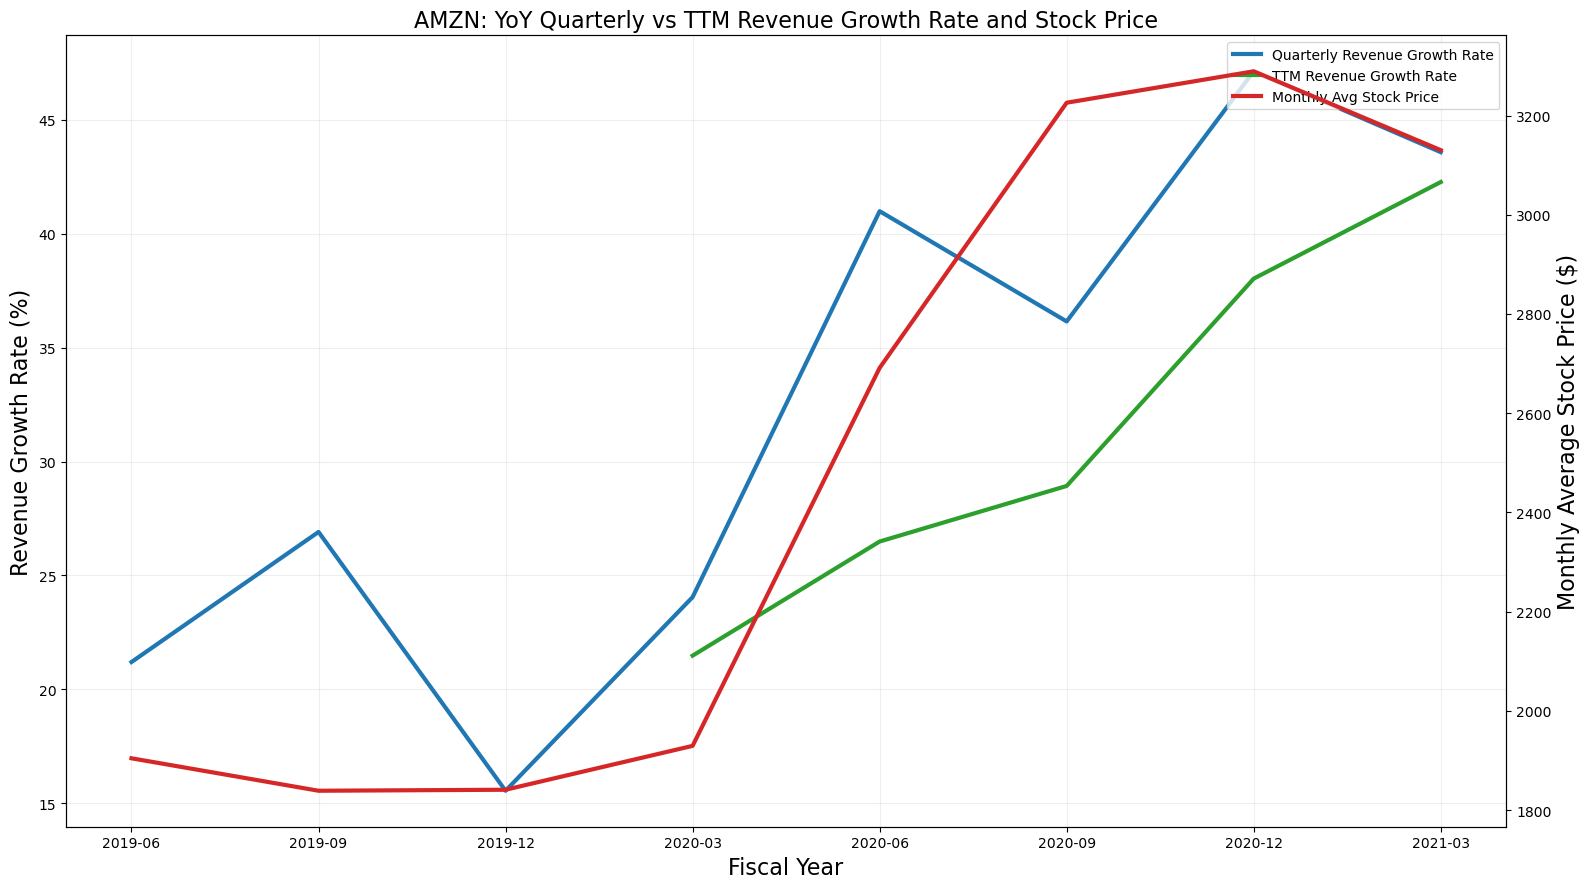

,fiscalDate,fiscalQuarter,totalRevenue,TTM_Revenue,Quarterly_Revenue_Growth,TTM_Revenue_Growth
11,2018-06-21,2,54442745038,NaN,NaN,NaN
10,2018-09-27,3,56651394151,NaN,NaN,NaN
9,2018-12-31,4,75866963933,NaN,NaN,NaN
8,2019-03-17,1,61427984650,2.483891e+11,NaN,NaN
7,2019-06-18,2,65984357160,2.599307e+11,21.20,NaN
6,2019-09-30,3,71898428744,2.751777e+11,26.91,NaN
5,2019-12-24,4,87664165406,2.869749e+11,15.55,NaN
4,2020-03-26,1,76203720900,3.017507e+11,24.05,21.48
3,2020-06-20,2,93030460115,3.287968e+11,40.99,26.49
2,2020-09-17,3,97887101186,3.547854e+11,36.15,28.93


In [36]:
revenue_growth_trend = growth('amzn', 'sandbox', 12)
revenue_growth_trend
